In [229]:
# Need to write a readme for this script

# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import requests
import geopandas
import urllib.request
import re
import os

In [244]:
final_cols = ['code','city','state','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

# Sun Data
sun_url = "https://www1.ncdc.noaa.gov/pub/data/ccd-data/pctpos15.dat"
sun_df = pd.read_fwf(sun_url)
sun_df.dropna(inplace=True) # drop rows without data on every month
sun_df[['tmp','state']] = sun_df['Unnamed: 0'].str.split(pat=",",expand=True)
sun_df['code'] = sun_df.apply(lambda row: row.tmp[0:5], axis=1)
sun_df['city'] = sun_df.apply(lambda row: row.tmp[5:], axis=1)
sun_df.drop(columns = ['Unnamed: 0','POR','tmp'],inplace=True)
sun_df = sun_df[sun_df['state'] !='PR']
sun_df = sun_df[final_cols]
for c in sun_df.columns[3:]:
    sun_df[c] = sun_df[c].astype('float64')

# Stack dataframe so sunshine values are all in a single column
sun_df_stacked = pd.DataFrame(columns = ['code','city','state','month','AvgDailySun'])
sun_ids_df = sun_df[['code','city','state']]
months = list(range(1,13))
months = [str(item).zfill(2) for item in months]
m = 0
for c in sun_df.columns[3:]:
    tmp = pd.DataFrame(columns = ['month','AvgDailySun'])
    tmp['AvgDailySun'] = sun_df[c]
    tmp['month'] = months[m]
    m = m+1
    tmp = pd.concat([sun_ids_df,tmp],axis=1)
    sun_df_stacked = pd.concat([sun_df_stacked, tmp],axis = 0)
print("SunData")
#print(sun_df_stacked.head(5))
#print("")
#print(sun_df_stacked.dtypes)

# Just look at state-average values for now
# we can look into specific cities later
avg_sun_df = sun_df_stacked.groupby(['state','month'],as_index=False)['AvgDailySun'].mean()
print(avg_sun_df.head(5))
#print(avg_sun_df['state'].value_counts())

SunData
  state month  AvgDailySun
0    AK    01    40.000000
1    AK    02    45.666667
2    AK    03    47.666667
3    AK    04    48.000000
4    AK    05    49.000000


In [245]:
# MaxTemperature Data
tmax_url = "https://www1.ncdc.noaa.gov/pub/data/ccd-data/nrmmax.txt"
tmax_df = pd.read_csv(tmax_url,names = ['code','city','tmp','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC','ANN'],skiprows = 1)
tmax_df.dropna(inplace=True) # drop rows without data on every month
tmax_df['state'] = tmax_df.apply(lambda row: row['tmp'][0:3], axis=1)
tmax_df['state'] = tmax_df['state'].str.strip()
tmax_df['city'] = tmax_df['city'].str.strip()
tmax_df['city'] = tmax_df['city'].str.replace(" AP","")
tmax_df['city'] = tmax_df['city'].str.replace(" C.O.","")
tmax_df['YRS'] = tmax_df.apply(lambda row: row.tmp[2:], axis=1)
tmax_df.drop(columns = ['tmp','YRS'],inplace=True)
tmax_df['code'] = tmax_df['code'].astype("str") # month can be str
tmax_df['code'] = tmax_df['code'].str.zfill(5) # pad month with zeros
tmax_df = tmax_df[tmax_df['state'] !='PR']
tmax_df = tmax_df[tmax_df['state'] !='PC']
tmax_df = tmax_df[tmax_df['state'] !='D.']
tmax_df = tmax_df[final_cols]

# Stack dataframe so temperature values are all in a single column
tmax_df_stacked = pd.DataFrame(columns = ['code','city','state','month','MaxTemp'])
tmax_ids_df = tmax_df[['code','city','state']]
months = list(range(1,13))
months = [str(item).zfill(2) for item in months]
m = 0
for c in tmax_df.columns[3:]:
    tmp = pd.DataFrame(columns = ['month','MaxTemp'])
    tmp['MaxTemp'] = tmax_df[c]
    tmp['month'] = months[m]
    m = m+1
    tmp = pd.concat([tmax_ids_df,tmp],axis=1)
    tmax_df_stacked = pd.concat([tmax_df_stacked, tmp],axis = 0)
print("MaxTempData")
print(tmax_df_stacked.head(5))
print("")
print(tmax_df_stacked.dtypes)

# Just look at state-average values for now
# we can look into specific cities later
avg_tmax_df = tmax_df_stacked.groupby(['state','month'],as_index=False)['MaxTemp'].mean()
print(avg_tmax_df.head(5))
#print(avg_tmax_df['state'].value_counts())

MaxTempData
    code        city state month  MaxTemp
0  13876  BIRMINGHAM    AL    01     53.8
1  03856  HUNTSVILLE    AL    01     51.2
2  13838      MOBILE    AL    01     60.0
3  13895  MONTGOMERY    AL    01     57.4
4  26451   ANCHORAGE    AK    01     23.1

code        object
city        object
state       object
month       object
MaxTemp    float64
dtype: object
  state month  MaxTemp
0    AK    01   18.320
1    AK    02   22.080
2    AK    03   28.175
3    AK    04   38.825
4    AK    05   50.915


In [246]:
# Wind Data
wind_url = 'https://www1.ncdc.noaa.gov/pub/data/ccd-data/wndspd15.dat'
wind_df = pd.read_fwf(wind_url)
wind_df.dropna(inplace=True) # drop rows without data on every month
wind_df.replace(" ","",regex=True,inplace=True)
wind_df[['tmp','state']] = wind_df['Unnamed: 0'].str.split(pat=",",expand=True)
wind_df['code'] = wind_df.apply(lambda row: row.tmp[0:5], axis=1)
wind_df['city'] = wind_df.apply(lambda row: row.tmp[5:], axis=1)
wind_df.drop(columns = ['Unnamed: 0','YRS','tmp'],inplace=True)
wind_df = wind_df[wind_df['state'] !='PR']
wind_df = wind_df[wind_df['state'] !='PC']
wind_df = wind_df[wind_df['state'] !='DC']
wind_df = wind_df[wind_df['state'] !='']
wind_df = wind_df[final_cols]

# Stack dataframe so wind values are all in a single column
wind_df_stacked = pd.DataFrame(columns = ['code','city','state','month','AvgWindSpeed'])
wind_ids_df = wind_df[['code','city','state']]
months = list(range(1,13))
months = [str(item).zfill(2) for item in months]
m = 0
for c in wind_df.columns[3:]:
    tmp = pd.DataFrame(columns = ['month','AvgWindSpeed'])
    tmp['AvgWindSpeed'] = wind_df[c]
    tmp['month'] = months[m]
    m = m+1
    tmp = pd.concat([wind_ids_df,tmp],axis=1)
    wind_df_stacked = pd.concat([wind_df_stacked, tmp],axis = 0)
print("AvgWindSpeedData")
print(wind_df_stacked.head(5))
print("")
print(wind_df_stacked.dtypes)

# Just look at state-average values for now
# we can look into specific cities later
avg_wind_df = wind_df_stacked.groupby(['state','month'],as_index=False)['AvgWindSpeed'].mean()
print(avg_wind_df.head(5))
#print(avg_wind_df['state'].value_counts())

AvgWindSpeedData
    code        city state month  AvgWindSpeed
0  13876  BIRMINGHAM    AL    01           6.9
1  03856  HUNTSVILLE    AL    01           8.3
2  13894      MOBILE    AL    01           8.6
3  13895  MONTGOMERY    AL    01           7.0
4  26451   ANCHORAGE    AK    01           6.4

code             object
city             object
state            object
month            object
AvgWindSpeed    float64
dtype: object
  state month  AvgWindSpeed
0    AK    01         8.905
1    AK    02         9.070
2    AK    03         8.980
3    AK    04         8.810
4    AK    05         8.695


In [257]:
# Combine sun, temp, wind data
# Make a state-month index that matches between three metric dataframes
avg_sun_df['StateMonth'] = avg_sun_df['state']+avg_sun_df['month']
avg_tmax_df['StateMonth'] = avg_tmax_df['state']+avg_tmax_df['month']
avg_wind_df['StateMonth'] = avg_wind_df['state']+avg_wind_df['month']

# Set index of each to the new "StateMonth" column
avg_sun_df.set_index('StateMonth',inplace=True)
avg_tmax_df.set_index('StateMonth',inplace=True)
avg_wind_df.set_index('StateMonth',inplace=True)

weather_df = pd.concat([avg_sun_df,avg_tmax_df['MaxTemp'],avg_wind_df['AvgWindSpeed']],sort=False,axis = 1)
print(weather_df.head(10))
print(weather_df.columns)

     state month  AvgDailySun  MaxTemp  AvgWindSpeed
AK01    AK    01    40.000000   18.320         8.905
AK02    AK    02    45.666667   22.080         9.070
AK03    AK    03    47.666667   28.175         8.980
AK04    AK    04    48.000000   38.825         8.810
AK05    AK    05    49.000000   50.915         8.695
AK06    AK    06    42.000000   59.550         8.255
AK07    AK    07    38.333333   62.560         7.780
AK08    AK    08    37.333333   60.250         7.875
AK09    AK    09    35.333333   52.480         8.425
AK10    AK    10    30.666667   38.235         8.685
Index(['state', 'month', 'AvgDailySun', 'MaxTemp', 'AvgWindSpeed'], dtype='object')


In [248]:
# Energy Data
stateID = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA",\
           "HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",\
           "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ",\
           "NM","NY","NC","ND","OH","OK","OR","PA","RI","SC",\
           "SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

#Energy Data Types
etypeID = ["ALL-","COW-","PEL-","NG-","NUC-","HYC-","WND-","WWW-","WAS-","TSN-"]

energy_df = pd.DataFrame(columns = ['seriesID','units','state','date','EnergyGen','EnergyType','StateName'])
for e in etypeID:
    for s in stateID:
        url = "http://api.eia.gov/series/?api_key=eb1984b5e857aa521c0c34345b0170aa&series_id=ELEC.GEN."+e+s+"-99.M"
        #print(url)
        r = requests.get(url)
        if len(r.text)>222:
            r = r.json()
            df1 = pd.DataFrame(r['series'][0])
            df1[['Date','EnergyGeneration']] = pd.DataFrame(df1.data.values.tolist(), index=df1.index)
            df1 = df1.join(pd.DataFrame(df1.name.str.split(':',5).tolist(),columns = ['1','2','3','4','5']))
            df1.drop(columns=['name','f','description','copyright','source','iso3166','start','end','updated','data','1','4','5'],inplace=True)
            df1.replace("USA-","",regex=True,inplace=True)
            df1.replace("thousand megawatthours","GWH",regex=True,inplace=True)
            df1.columns = ['seriesID','units','state','date','EnergyGen','EnergyType','StateName']
            df1['date'] = pd.to_datetime(df1['date'],yearfirst=True,format = '%Y%m')
            energy_df = pd.concat([energy_df, df1])
print(energy_df.head(5))
print(energy_df.dtypes)

               seriesID units state       date    EnergyGen   EnergyType  \
0  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-11-01  10788.26989   all fuels    
1  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-10-01  10874.00613   all fuels    
2  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-09-01  12823.09790   all fuels    
3  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-08-01  13987.51427   all fuels    
4  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-07-01  14504.17413   all fuels    

   StateName  
0   Alabama   
1   Alabama   
2   Alabama   
3   Alabama   
4   Alabama   
seriesID              object
units                 object
state                 object
date          datetime64[ns]
EnergyGen            float64
EnergyType            object
StateName             object
dtype: object


In [251]:
# get an average energy profile for recent years (2016+)
energy_df['month'] = energy_df.apply(lambda row: row['date'].month, axis=1)
energy_df['month'] = energy_df['month'].astype("str") # month can be str
energy_df['month'] = energy_df['month'].str.zfill(2) # pad month with zeros
energy_df['year'] = energy_df.apply(lambda row: row['date'].year, axis=1)
energy_df = energy_df.loc[energy_df['year']>=2016,:] # just look at 2017 data for now
avg_energy_df = energy_df.groupby(['seriesID','units','state','month','EnergyType','StateName'],as_index=False)['EnergyGen'].mean()
print(avg_energy_df.head(5))
print(len(avg_energy_df))

               seriesID units state month   EnergyType StateName   EnergyGen
0  ELEC.GEN.ALL-AK-99.M   GWH    AK    01   all fuels    Alaska   623.971207
1  ELEC.GEN.ALL-AK-99.M   GWH    AK    02   all fuels    Alaska   530.784727
2  ELEC.GEN.ALL-AK-99.M   GWH    AK    03   all fuels    Alaska   569.288383
3  ELEC.GEN.ALL-AK-99.M   GWH    AK    04   all fuels    Alaska   496.511673
4  ELEC.GEN.ALL-AK-99.M   GWH    AK    05   all fuels    Alaska   487.000997
5400
50


In [283]:
# US Map GeoPanda
# download census data with state and county boundaries
# https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html (save to computer, unzip, and find .shp file)
cwd = os.getcwd()
cdata = geopandas.read_file(cwd+'/UScounties/cb_2017_us_county_20m.shp')
cdata.columns =['StateID','CountyID','COUNTYNS','AFFGEOID','GEOID','County','LSAD','ALAND','AWATER','geometry']
cdata.replace(" Borough","",regex=True,inplace=True)
cdata.replace(" Census Area","",regex=True,inplace=True)
cdata.replace(" Municipality","",regex=True,inplace=True)
cdata.replace(" Parish","",regex=True,inplace=True)
cdata.replace(" Municipio","",regex=True,inplace=True)
cdata.replace(" City and","",regex=True,inplace=True)
cdata.replace("LaSalle","La Salle",regex=True,inplace=True)
cdata.replace("DoÃ±a Ana","Dona Ana",regex=True,inplace=True)
cdata['CountyID_StateID'] = cdata['CountyID'].astype(str) + "_" +  cdata['StateID'].astype(str)

# Need conversion table to get state info for each county
# Also available online
convdata = pd.read_csv('https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',\
                       header=None,\
                       names=['State','StateID','CountyID','County','remove'],\
                       dtype='str');
convdata = convdata[['State','StateID','CountyID','County']]
convdata.replace(" County","",regex=True,inplace=True)
convdata.replace(" Borough","",regex=True,inplace=True)
convdata.replace(" Census Area","",regex=True,inplace=True)
convdata.replace(" Municipality","",regex=True,inplace=True)
convdata.replace(" Parish","",regex=True,inplace=True)
convdata.replace(" Municipio","",regex=True,inplace=True)
convdata.replace(" City and","",regex=True,inplace=True)
convdata.replace("LaSalle","La Salle",regex=True,inplace=True)
convdata.replace("DoÃ±a Ana","Dona Ana",regex=True,inplace=True)
convdata = convdata[convdata['State'] != "PR"]
convdata['CountyID_StateID'] = convdata['CountyID'].astype(str) + "_" +  convdata['StateID'].astype(str)

# Join them on a new StateID_CountyID index
convdata.set_index('CountyID_StateID',inplace=True)
cdata.set_index('CountyID_StateID',inplace=True)
# Join CountyData and ConversionData on CountyID_StateID
geo_df = convdata.join(cdata,on='CountyID_StateID',how='inner',lsuffix='_1',rsuffix='_2')
geo_df = geo_df.loc[:,['State','StateID_1','CountyID_1','County_1','COUNTYNS','AFFGEOID','GEOID','LSAD','ALAND','AWATER','geometry']]
geo_df.columns = ['state','stateID','countyID','county','COUNTYNS','AFFGEOID','GEOID','LSAD','ALAND','AWATER','geometry']
print("GeoDataframe")
print(geo_df.head(5))
print(len(geo_df))

GeoDataframe
                 state stateID countyID   county  COUNTYNS        AFFGEOID  \
CountyID_StateID                                                             
001_01              AL      01      001  Autauga  00161526  0500000US01001   
003_01              AL      01      003  Baldwin  00161527  0500000US01003   
005_01              AL      01      005  Barbour  00161528  0500000US01005   
007_01              AL      01      007     Bibb  00161529  0500000US01007   
009_01              AL      01      009   Blount  00161530  0500000US01009   

                  GEOID LSAD       ALAND      AWATER  \
CountyID_StateID                                       
001_01            01001   06  1539614693    25744269   
003_01            01003   06  4117605847  1133109409   
005_01            01005   06  2292144656    50538698   
007_01            01007   06  1612165763     9603798   
009_01            01009   06  1670079465    15039864   

                                               

In [266]:
# update geo_df with columns of interest
# indexes must match again (just state)
geo_df.set_index('state',inplace=True)
weather_df.set_index('state',inplace=True)

KeyError: 'state'

In [272]:
test = geo_df.join(weather_df,on='state',how='outer',lsuffix='_1',rsuffix='_2')
print(test.head(5))
print(len(test))
test = geopandas.GeoDataFrame(test)

                 state stateID countyID   county  COUNTYNS        AFFGEOID  \
CountyID_StateID                                                             
001_01              AL      01      001  Autauga  00161526  0500000US01001   
001_01              AL      01      001  Autauga  00161526  0500000US01001   
001_01              AL      01      001  Autauga  00161526  0500000US01001   
001_01              AL      01      001  Autauga  00161526  0500000US01001   
001_01              AL      01      001  Autauga  00161526  0500000US01001   

                  GEOID LSAD         ALAND      AWATER  \
CountyID_StateID                                         
001_01            01001   06  1.539615e+09  25744269.0   
001_01            01001   06  1.539615e+09  25744269.0   
001_01            01001   06  1.539615e+09  25744269.0   
001_01            01001   06  1.539615e+09  25744269.0   
001_01            01001   06  1.539615e+09  25744269.0   

                                              

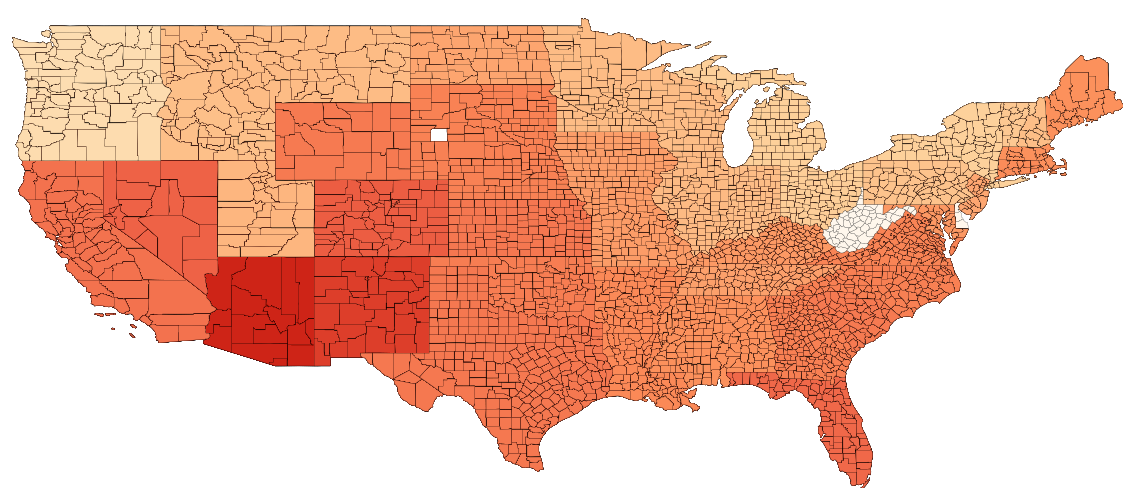

In [275]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
test.plot(column='AvgDailySun', legend=False, ax=ax,cmap='OrRd',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 100);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

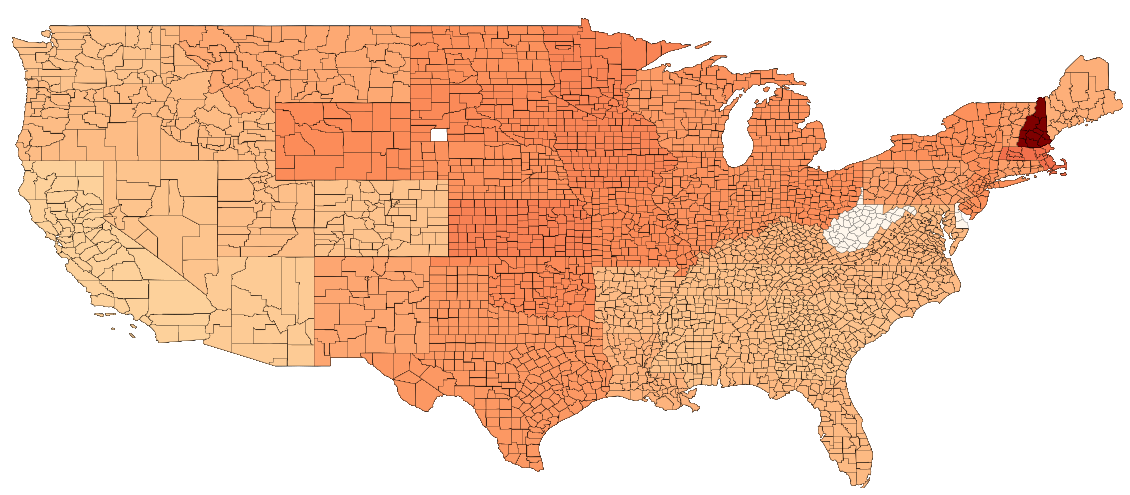

In [277]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
test.plot(column='AvgWindSpeed', legend=False, ax=ax,cmap='OrRd',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 20);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

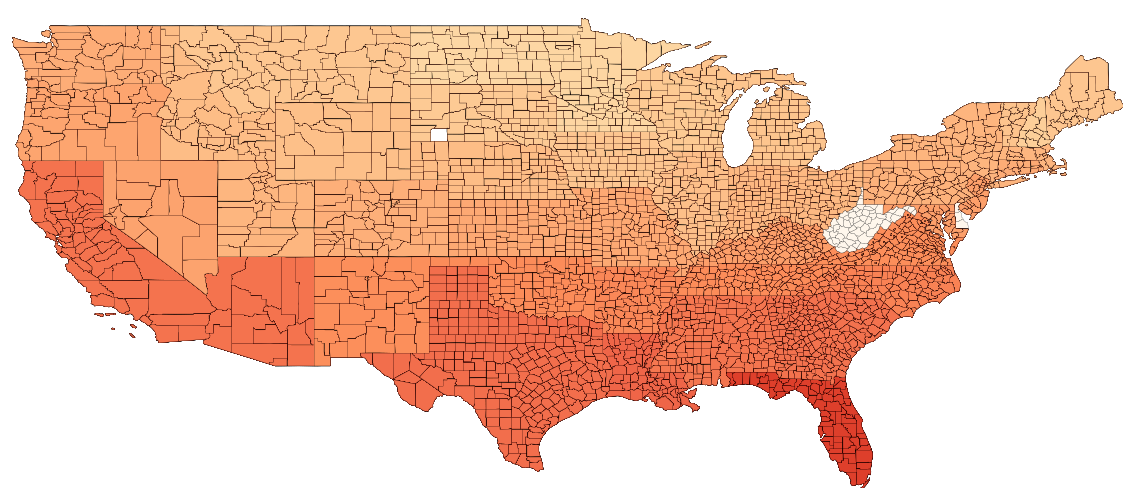

In [279]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
test.plot(column='MaxTemp', legend=False, ax=ax,cmap='OrRd',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 100);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)